# Introduction #

Welcome to **Petals to the Metal**! This tutorial will guide you through creating an image classifier in Keras and training it on the TPU. By the end, you should have a submission-ready notebook, which you can use to jump-start your own ideas.

# Load the Helper Functions #

Attached to the starter template is a utility script called [`petal_helper`](https://www.kaggle.com/ryanholbrook/petal-helper). It contains a number of helper functions related to data loading and visualization. The following cell will import them into your notebook session. We'll also import TensorFlow, which we'll use to create our model.

In [1]:
from petal_helper import *

import tensorflow as tf

Tensorflow version 2.2.0
Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


# Distribution Strategy #

A TPU has eight different *cores* and each of these cores acts as its own accelerator. (A TPU is sort of like having eight GPUs in one machine.) We tell TensorFlow how to make use of all these cores at once through a **distribution strategy**. Run the following cell to create the distribution strategy that we'll later apply to our model.

In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


TensorFlow will distribute training among the eight TPU cores by creating eight different *replicas* of your model. Since we haven't connected the TPU yet, it tells us we only have one model replica (for CPU or GPU training). Later, you'll turn on the TPU while committing your notebook. Then you'll see all eight replicas.

# Load the Competition Data #

The next three functions are preloaded with the `petals_helper` script, but we'll show them here so you can see how data pipelines are created in TensorFlow. As you learn more about data pipelines, you may want to experiment with modifying these functions. (It's not so important to understand the details for now though.)

In [3]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In your starter template, the following cell will create your training and validation datasets.

In [4]:
ds_train = get_training_dataset()
ds_valid = get_validation_dataset()

print("Training:", ds_train)
print("Validation:", ds_valid)

Training: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>


These are `tf.data.Dataset` objects. You can think about a dataset in TensorFlow as a *stream* of data records. We won't get into details here, but check out [this guide](https://www.tensorflow.org/guide/data) for more on working with the `tf.data` API.

# Explore the Data #

Imported with `petal_helper` is a list of the names of the flower species we'll classify our images into. The following cell has some ideas of things you could try.

In [5]:
print ("Number of classes: {}".format(len(CLASSES)))

print ("First five classes, sorted alphabetically:")
for name in sorted(CLASSES)[:5]:
    print(name)

Number of classes: 104
First five classes, sorted alphabetically:
alpine sea holly
anthurium
artichoke
azalea
balloon flower


Usually, model training in TensorFlow is done in *batches*. Your dataset has already been put into batches, with the batch size determined by default in `petals_helper`.

In [6]:
print(BATCH_SIZE)

128


You can display a single batch of images from a dataset with one of our helper functions. Try typing the code below into a new cell. Run it to see some examples from the training data.

In [7]:
# Peek at training data
one_batch = next(iter(ds_train.unbatch().batch(20))
display_batch_of_images(one_batch)

SyntaxError: invalid syntax (<ipython-input-7-1a49d57d7883>, line 3)

# Define Model #

Now you're ready to create a neural network for classifying images! The method we'll use is called *transfer learning*. If you're unfamiliar with this idea, it just means that we'll reuse part of model that's already been trained on a dataset similar to our training data (in this case, [ImageNet](http://image-net.org/)).

Recall that we created a **distribution strategy** earlier. This distribution strategy contains a [context manager](https://docs.python.org/3/reference/compound_stmts.html#with), `strategy.scope()`, that tells TensorFlow how to distribute data to the TPU cores. It's important that you define your model inside this context when training on a TPU.

The code cell below shows you how to create an image classifier in TensorFlow that will run on a TPU. We've chosen to use a pretrained model called **VGG16**. Start with this one for now, but later you might want to experiment with some of [the other models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) included with Keras. ([Xception](https://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception) wouldn't be a bad choice.)

In [8]:
with strategy.scope():
    pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 104)               53352     
Total params: 14,768,040
Trainable params: 53,352
Non-trainable params: 14,714,688
_________________________________________________________________


If you set up your model definition correctly, after running this cell you should see a summary of the model you created.

# Training #

Now we're ready to set up the model training. This just consists of defining some define some configuration parameters and then calling the `fit` method of our model. The `history` object contains the values at each epoch for the loss and metrics defined in the previous cell.

In [9]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Define training epochs
EPOCHS = 12
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)

Epoch 1/12
99/99 [==============================] - 26s 264ms/step - sparse_categorical_accuracy: 0.0938 - loss: 4.1253 - val_sparse_categorical_accuracy: 0.1301 - val_loss: 3.8945
Epoch 2/12
99/99 [==============================] - 17s 170ms/step - sparse_categorical_accuracy: 0.1619 - loss: 3.7701 - val_sparse_categorical_accuracy: 0.1902 - val_loss: 3.6530
Epoch 3/12
99/99 [==============================] - 16s 164ms/step - sparse_categorical_accuracy: 0.2051 - loss: 3.5537 - val_sparse_categorical_accuracy: 0.2322 - val_loss: 3.4600
Epoch 4/12
99/99 [==============================] - 15s 156ms/step - sparse_categorical_accuracy: 0.2416 - loss: 3.3707 - val_sparse_categorical_accuracy: 0.2522 - val_loss: 3.3025
Epoch 5/12
99/99 [==============================] - 15s 156ms/step - sparse_categorical_accuracy: 0.2664 - loss: 3.2219 - val_sparse_categorical_accuracy: 0.2732 - val_loss: 3.1706
Epoch 6/12
99/99 [==============================] - 16s 157ms/step - sparse_categorical_accurac

This next cell shows how the loss and metrics progressed during training. Not the best, but at least it converges!

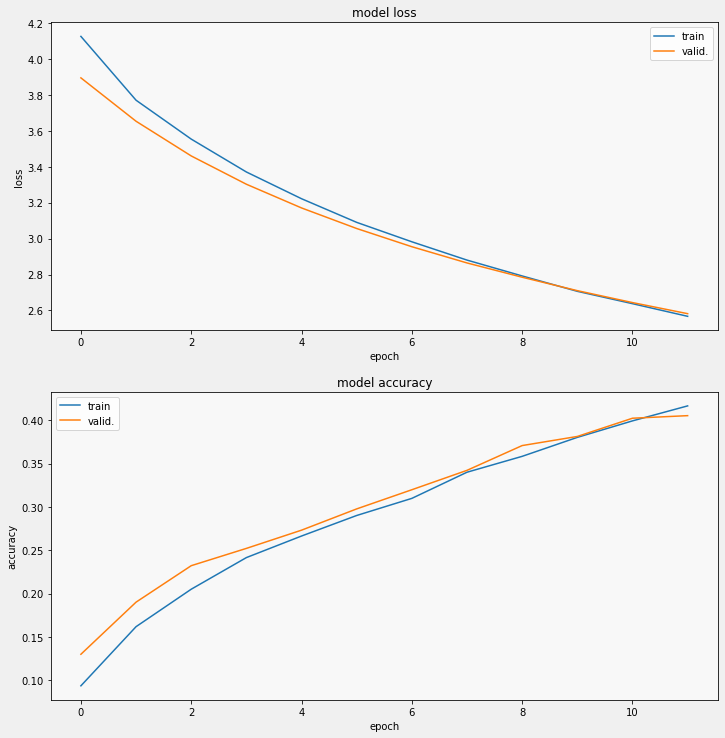

In [10]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

# Validation #

## Confusion Matrix ##

Before making your final predictions on the test set, it's a good idea to evaluate your model's predictions on the validation set. This can help you diagnose problems in training or suggest ways your model could be improved. The following cell will create a set of class predictions for the validation set and then display a confusion matrix showing how your model performed on every class.

In [11]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

You might be familiar with metrics like [F1-score](https://en.wikipedia.org/wiki/F1_score) or [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). This cell will compute these metrics and display them along with the confusion matrix. (These metrics are defined in the Scikit-learn module `sklearn.metrics`; we've imported them in the helper script for you.)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


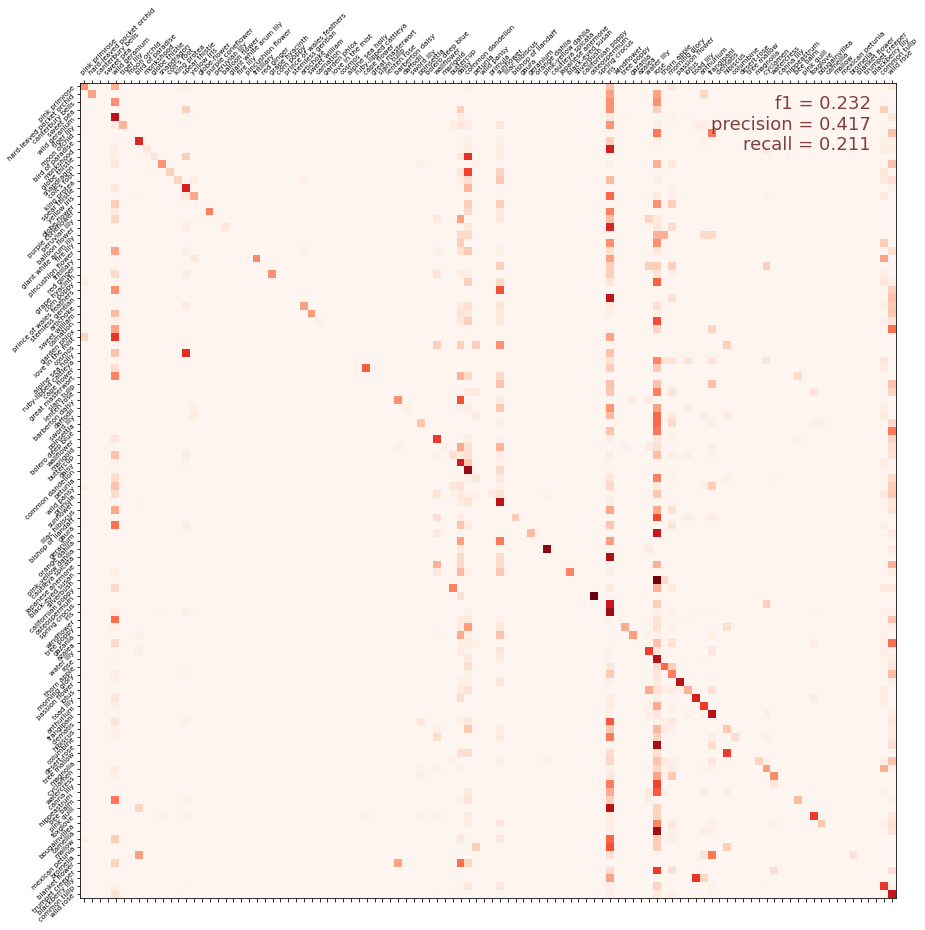

In [12]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

## Visual Validation ##

It can also be helpful to look at some examples from the validation set and see what class your model predicted for them. Sometimes, this can reveal patterns in the kinds of images your model has trouble with.

This cell will set up the validation set to display 20 images at a time &ndash you can change this to display more or fewer, if you like.

In [13]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

This next cell shows images from the validation set along with their actual and predicted class. You can run the cell again to see another set of images.

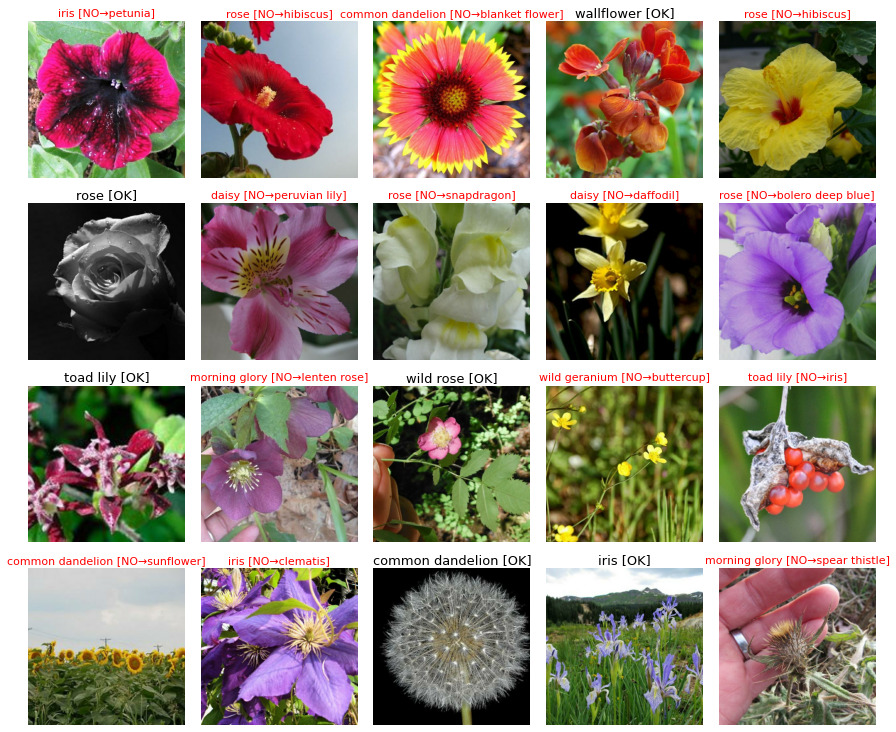

In [14]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# Predictions #

Once you're satisfied with everything, you're ready to make predictions on the test set. This is what you'll submit to get your score on the leaderboard.

In [15]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

Computing predictions...
[ 67  28 103 ...  48  53  53]
Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,103
00e4f514e,103
59d1b6146,53
8d808a07b,53
aeb67eefb,103
53cfc6586,48
aaa580243,67


# Your Turn! #

## Create Your Notebook ##

Now it's your turn!

We've provided a starter notebook that will help you get set up. Follow the next link and click the blue "Copy and Edit" button in the upper-right corner. Follow along with the remainder of this tutorial while you work in your new notebook.

- [Starter Notebook](https://www.kaggle.com/ryanholbrook/petals-to-the-metal-example-submission)

## Commit Your Notebook ##

Now we'll commit the notebook with the TPU engaged. First, click on the blue button to the upper right that says **Save Version**.

<figure>
<img src="https://i.imgur.com/ebMUMSq.png" alt="The blue Save Version button." width=300>
</figure>

Now choose **Advanced Settings**.

<figure>
<img src="https://i.imgur.com/FJVJC3v.png" alt="Advanced Settings in the Version menu." width=600>
</figure>

Now select **Run with TPU for this session** from the dropdown menu and click the blue **Save** button.

<figure>
<img src="https://i.imgur.com/1cB5ykf.png" alt="The Accelerator dropdown menu." width=600>
</figure>

Now select **Save & Run All (Commit)** and click the blue **Save** button.

<figure>
<img src="https://i.imgur.com/VYN8gho.png" alt="The Save Version menu." width=600>
</figure>

Commiting your notebook will run a fresh copy of the notebook and save the output. We've already prepared the code for making predictions in your exercise notebook, so once the commit is finished, you'll be able to submit your model's predictions. The commit may take a while to finish, but there's no harm in doing something else while it's running and coming back later.

Once it's finished, this dialog should appear:

<figure>
<img src="https://i.imgur.com/hjspvlJ.png" alt="The Done dialog." width=300>
</figure>

Clicking on **View** will take you to the notebook viewer. Continue this tutorial from there.

## Make a Submission ##

And now you're ready to make a submission! Assuming you're still in the notebook viewer... **TODO**

<figure>
<img src="https://i.imgur.com/j00mDeI.png" alt="The Save Version menu." width=300>
</figure>

# Conclusion #

**TODO**